# Imports

In [ ]:
import numpy as np
import pandas as pd
import sqlalchemy

import itertools
import os
from datetime import datetime


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns 

In [ ]:
from functions import load_balanced_df, load_balanced_df2, confusion_matrix

# Balanced Dataset

Load and combine files for from each protocol

In [45]:
HOPOPT_df = load_balanced_df(directory='HOPOPT', sample_size=1000)
HOPOPT_df.shape

(2558, 83)

In [46]:
TCP_df = load_balanced_df(directory='TCP', sample_size=1000)
TCP_df.shape

(18482, 83)

In [47]:
UDP_df = load_balanced_df(directory='UDP', sample_size=1000)
UDP_df.shape

(55000, 83)

Combine all protocols into balanced dataset

In [48]:
balanced_df = pd.concat([HOPOPT_df, TCP_df, UDP_df])
del HOPOPT_df, TCP_df, UDP_df
balanced_df.reset_index(drop=True, inplace=True)
balanced_df.shape

(76040, 83)

In [49]:
balanced_df.columns

Index(['Flow_ID', 'Flow_Duration', 'Fwd_Total_Pkts', 'Bwd_Total_Pkts',
       'Fwd_Total_Bytes', 'Bwd_Total_Bytes', 'Fwd_Pkt_Length_Max',
       'Fwd_Pkt_Length_Min', 'Fwd_Pkt_Length_Mean', 'Fwd_Pkt_Length_Std',
       'Bwd_Pkt_Length_Max', 'Bwd_Pkt_Length_Min', 'Bwd_Pkt_Length_Mean',
       'Bwd_Pkt_Length_Std', 'Flow_Bytes_Sec', 'Flow_Pkts_Sec',
       'Flow_IAT_Mean', 'Flow_IAT_Std', 'Flow_IAT_Max', 'Flow_IAT_Min',
       'Fwd_IAT_Total', 'Fwd_IAT_Mean', 'Fwd_IAT_Std', 'Fwd_IAT_Max',
       'Fwd_IAT_Min', 'Bwd_IAT_Total', 'Bwd_IAT_Mean', 'Bwd_IAT_Std',
       'Bwd_IAT_Max', 'Bwd_IAT_Min', 'Fwd_PSH_Flags', 'Bwd_PSH_Flags',
       'Fwd_URG_Flags', 'Bwd_URG_Flags', 'Fwd_Header_Length',
       'Bwd_Header_Length', 'Fwd_Pkts_Sec', 'Bwd_Pkts_Sec', 'Pkt_Length_Min',
       'Pkt_Length_Max', 'Pkt_Length_Mean', 'Pkt_Length_Std', 'Pkt_Length_Var',
       'FIN_Flag_Count', 'SYN_Flag_Count', 'RST_Flag_Count', 'PSH_Flag_Count',
       'ACK_Flag_Count', 'URG_Flag_Count', 'CWE_Flag_Count', 'ECE_Fl

Change all benign lables to simply 'benign'

In [50]:
benign_filt = balanced_df['Malicious'] == 0
balanced_df['Label'] = np.where(benign_filt, 'Benign', balanced_df['Label'])

Check target distributions

In [51]:
balanced_df['Malicious'].value_counts()

1    38020
0    38020
Name: Malicious, dtype: int64

In [52]:
balanced_df['Label'].value_counts()

Benign     38020
TFTP        3791
Syn         3710
DNS         3695
NTP         3656
NetBIOS     3594
SNMP        3591
UDP         3564
MSSQL       3187
LDAP        3177
Portmap     3055
SSDP        3000
Name: Label, dtype: int64

In [3]:
balanced_df = load_balanced_df2(sample_size=1000)
balanced_df.shape

(22000, 83)

Change all benign lables to simply 'benign'

In [4]:
benign_filt = balanced_df['Malicious'] == 0
balanced_df['Label'] = np.where(benign_filt, 'Benign', balanced_df['Label'])

Check target distributions

In [5]:
balanced_df['Malicious'].value_counts()

1    11000
0    11000
Name: Malicious, dtype: int64

In [6]:
balanced_df['Label'].value_counts()

Benign     11000
LDAP        1000
TFTP        1000
Syn         1000
Portmap     1000
UDP         1000
SSDP        1000
NTP         1000
DNS         1000
SNMP        1000
MSSQL       1000
NetBIOS     1000
Name: Label, dtype: int64

## Binary Classification (Balanced)

### Train Test Split

In [7]:
bal_binary_X = balanced_df.drop(['Flow_ID', 'Label', 'HOPOPT', 'Malicious'], axis=1)
bal_binary_y = balanced_df['Malicious']

bal_binary_X_train, bal_binary_X_test, bal_binary_y_train, bal_binary_y_test = train_test_split(
    bal_binary_X, bal_binary_y, test_size = 0.25, random_state = 0)

### Standard Scalar

In [8]:
std_scaler = StandardScaler()

bal_binary_X_train_scl = std_scaler.fit_transform(bal_binary_X_train)
bal_binary_X_test_scl = std_scaler.transform(bal_binary_X_test)

### Dummy Classifier

In [9]:
bal_binary_dummy = DummyClassifier()
bal_binary_dummy.fit(bal_binary_X_train_scl, bal_binary_y_train)
bal_binary_dummy_preds = bal_binary_dummy.predict(bal_binary_X_test_scl)

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


In [10]:
bal_binary_dummy_acc = accuracy_score(bal_binary_dummy_preds, bal_binary_y_test)
bal_binary_dummy_f1 = f1_score(bal_binary_dummy_preds, bal_binary_y_test)

print('Accuracy:', bal_binary_dummy_acc)
print('      F1:', bal_binary_dummy_f1)

Accuracy: 0.4950909090909091
      F1: 0.49554950045413265


### Gaussian Naive Bayes 

In [11]:
bal_binary_gnb = GaussianNB()
bal_binary_gnb.fit(bal_binary_X_train_scl, bal_binary_y_train)
bal_binary_gnb_preds = bal_binary_gnb.predict(bal_binary_X_test_scl)

In [12]:
bal_binary_gnb_acc = accuracy_score(bal_binary_gnb_preds, bal_binary_y_test)
bal_binary_gnb_f1 = f1_score(bal_binary_gnb_preds, bal_binary_y_test)

print('Accuracy:', bal_binary_gnb_acc)
print('      F1:', bal_binary_gnb_f1)

Accuracy: 0.8223636363636364
      F1: 0.8438548825315646


### Decision Tree

In [13]:
bal_binary_dt = DecisionTreeClassifier(random_state=0)
bal_binary_dt.fit(bal_binary_X_train_scl, bal_binary_y_train)
bal_binary_dt_preds = bal_binary_dt.predict(bal_binary_X_test_scl)

In [14]:
bal_binary_dt_acc = accuracy_score(bal_binary_dt_preds, bal_binary_y_test)
bal_binary_dt_f1 = f1_score(bal_binary_dt_preds, bal_binary_y_test)

print('Accuracy:', bal_binary_dt_acc)
print('      F1:', bal_binary_dt_f1)

Accuracy: 0.9990909090909091
      F1: 0.9990830735375024


### K Nearest Neighbors

In [15]:
bal_binary_knn = KNeighborsClassifier()
bal_binary_knn.fit(bal_binary_X_train_scl, bal_binary_y_train)
bal_binary_knn_preds = bal_binary_knn.predict(bal_binary_X_test_scl)

In [16]:
bal_binary_knn_acc = accuracy_score(bal_binary_knn_preds, bal_binary_y_test)
bal_binary_knn_f1 = f1_score(bal_binary_knn_preds, bal_binary_y_test)

print('Accuracy:', bal_binary_knn_acc)
print('      F1:', bal_binary_knn_f1)

Accuracy: 0.9972727272727273
      F1: 0.9972542559033498


### Random Forest

In [17]:
bal_binary_rf = RandomForestClassifier(random_state=0, n_jobs=-1)
bal_binary_rf.fit(bal_binary_X_train_scl, bal_binary_y_train)
bal_binary_rf_preds = bal_binary_rf.predict(bal_binary_X_test_scl)

In [18]:
bal_binary_rf_acc = accuracy_score(bal_binary_rf_preds, bal_binary_y_test)
bal_binary_rf_f1 = f1_score(bal_binary_rf_preds, bal_binary_y_test)

print('Accuracy:', bal_binary_rf_acc)
print('      F1:', bal_binary_rf_f1)

Accuracy: 0.9987272727272727
      F1: 0.9987153606166268


### XGBoost

In [19]:
bal_binary_xgb = XGBClassifier(random_state=0, n_jobs=-1)
bal_binary_xgb.fit(bal_binary_X_train_scl, bal_binary_y_train)
bal_binary_xgb_preds = bal_binary_xgb.predict(bal_binary_X_test_scl)

In [20]:
bal_binary_xgb_acc = accuracy_score(bal_binary_xgb_preds, bal_binary_y_test)
bal_binary_xgb_f1 = f1_score(bal_binary_xgb_preds, bal_binary_y_test)

print('Accuracy:', bal_binary_xgb_acc)
print('      F1:', bal_binary_xgb_f1)

Accuracy: 1.0
      F1: 1.0


### Feature Importances

Decision Tree

In [21]:
bal_binary_dt_features = dict(zip(bal_binary_X.columns, bal_binary_dt.feature_importances_))
bal_binary_dt_features = sorted(bal_binary_dt_features.items(), key=lambda x: x[1], reverse=True)
bal_binary_dt_features[:10]

[('Fwd_Init_Win_Bytes', 0.6428306338135531),
 ('Pkt_Size_Mean', 0.1930210912747058),
 ('ACK_Flag_Count', 0.06833403894335129),
 ('URG_Flag_Count', 0.018841893148837326),
 ('Fwd_IAT_Std', 0.0170630742980684),
 ('Flow_IAT_Max', 0.01288170243231033),
 ('PSH_Flag_Count', 0.011608792134848533),
 ('Fwd_PSH_Flags', 0.007789010462476875),
 ('Fwd_Total_Pkts', 0.006817833494654901),
 ('Flow_IAT_Min', 0.006603003802723726)]

Random Forest

In [22]:
bal_binary_rf_features = dict(zip(bal_binary_X.columns, bal_binary_rf.feature_importances_))
bal_binary_rf_features = sorted(bal_binary_rf_features.items(), key=lambda x: x[1], reverse=True)
bal_binary_rf_features[:10]

[('Fwd_Init_Win_Bytes', 0.13006379633919796),
 ('TCP', 0.07753190823840336),
 ('Pkt_Length_Min', 0.06621859113300392),
 ('UDP', 0.05545832025128266),
 ('PSH_Flag_Count', 0.04537413078590603),
 ('URG_Flag_Count', 0.04036536486130466),
 ('Fwd_Pkt_Length_Min', 0.03883967725701086),
 ('Pkt_Size_Mean', 0.032571640316125056),
 ('Fwd_IAT_Total', 0.02891790669537423),
 ('ACK_Flag_Count', 0.02445749558583487)]

XGBoost

In [23]:
bal_binary_xgb_features = dict(zip(bal_binary_X.columns, bal_binary_xgb.feature_importances_))
bal_binary_xgb_features = sorted(bal_binary_xgb_features.items(), key=lambda x: x[1], reverse=True)
bal_binary_xgb_features[:10]

[('Pkt_Size_Mean', 0.36486617),
 ('CWE_Flag_Count', 0.14011626),
 ('Fwd_Init_Win_Bytes', 0.13416831),
 ('Fwd_Seg_Size_Min', 0.116157554),
 ('Fwd_PSH_Flags', 0.06968633),
 ('URG_Flag_Count', 0.038217895),
 ('Flow_Duration', 0.02600883),
 ('PSH_Flag_Count', 0.017169759),
 ('Bwd_IAT_Min', 0.016114924),
 ('Flow_IAT_Min', 0.015088932)]

## Multiclass Classification (Balanced)

### Train Test Split

In [24]:
bal_multi_X = balanced_df.drop(['Flow_ID', 'Label', 'HOPOPT', 'Malicious'], axis=1)
bal_multi_y = balanced_df['Label']

bal_multi_X_train, bal_multi_X_test, bal_multi_y_train, bal_multi_y_test = train_test_split(
    bal_multi_X, bal_multi_y, test_size = 0.25, random_state = 0)

### Standard Scalar

In [25]:
std_scaler = StandardScaler()

bal_multi_X_train_scl = std_scaler.fit_transform(bal_multi_X_train)
bal_multi_X_test_scl = std_scaler.transform(bal_multi_X_test)

### Dummy Classifier

In [26]:
bal_multi_dummy = DummyClassifier()
bal_multi_dummy.fit(bal_multi_X_train_scl, bal_multi_y_train)
bal_multi_dummy_preds = bal_multi_dummy.predict(bal_multi_X_test_scl)

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


In [27]:
bal_multi_dummy_acc = accuracy_score(bal_multi_dummy_preds, bal_binary_y_test)
bal_multi_dummy_f1 = f1_score(bal_multi_dummy_preds, bal_multi_y_test, average='weighted')

print('Accuracy:', bal_multi_dummy_acc)
print('      F1:', bal_multi_dummy_f1)

Accuracy: 0.0
      F1: 0.2687701809280785


### Gaussian Naive Bayes

In [28]:
bal_multi_gnb = GaussianNB()
bal_multi_gnb.fit(bal_multi_X_train_scl, bal_multi_y_train)
bal_multi_gnb_preds = bal_multi_gnb.predict(bal_multi_X_test_scl)

In [29]:
bal_multi_gnb_acc = accuracy_score(bal_multi_gnb_preds, bal_multi_y_test)
bal_multi_gnb_f1 = f1_score(bal_multi_gnb_preds, bal_multi_y_test, average='weighted')

print('Accuracy:', bal_multi_gnb_acc)
print('      F1:', bal_multi_gnb_f1)

Accuracy: 0.6616363636363637
      F1: 0.6475816235772198


### Decision Tree

In [30]:
bal_multi_dt = DecisionTreeClassifier(random_state=0)
bal_multi_dt.fit(bal_multi_X_train_scl, bal_multi_y_train)
bal_multi_dt_preds = bal_multi_dt.predict(bal_multi_X_test_scl)

In [31]:
bal_multi_dt_acc = accuracy_score(bal_multi_dt_preds, bal_multi_y_test)
bal_multi_dt_f1 = f1_score(bal_multi_dt_preds, bal_multi_y_test, average='weighted')

print('Accuracy:', bal_multi_dt_acc)
print('      F1:', bal_multi_dt_f1)

Accuracy: 0.924
      F1: 0.9326734573116471


### K Nearest Neighbors

In [32]:
bal_multi_knn = KNeighborsClassifier()
bal_multi_knn.fit(bal_multi_X_train_scl, bal_multi_y_train)
bal_multi_knn_preds = bal_multi_knn.predict(bal_multi_X_test_scl)

In [33]:
bal_multi_knn_acc = accuracy_score(bal_multi_knn_preds, bal_multi_y_test)
bal_multi_knn_f1 = f1_score(bal_multi_knn_preds, bal_multi_y_test, average='weighted')

print('Accuracy:', bal_multi_knn_acc)
print('      F1:', bal_multi_knn_f1)

Accuracy: 0.9196363636363636
      F1: 0.9262123423027895


### Random Forest

In [34]:
bal_multi_rf = RandomForestClassifier(random_state=0, n_jobs=-1)
bal_multi_rf.fit(bal_multi_X_train_scl, bal_multi_y_train)
bal_multi_rf_preds = bal_multi_rf.predict(bal_multi_X_test_scl)

In [35]:
bal_multi_rf_acc = accuracy_score(bal_multi_rf_preds, bal_multi_y_test)
bal_multi_rf_f1 = f1_score(bal_multi_rf_preds, bal_multi_y_test, average='weighted')

print('Accuracy:', bal_multi_rf_acc)
print('      F1:', bal_multi_rf_f1)

Accuracy: 0.928
      F1: 0.9368365960547292


### XGBoost

In [36]:
bal_multi_xgb = XGBClassifier(random_state=0, n_jobs=-1)
bal_multi_xgb.fit(bal_multi_X_train_scl, bal_multi_y_train)
bal_multi_xgb_preds = bal_multi_xgb.predict(bal_multi_X_test_scl)

In [37]:
bal_multi_xgb_acc = accuracy_score(bal_multi_xgb_preds, bal_multi_y_test)
bal_multi_xgb_f1 = f1_score(bal_multi_xgb_preds, bal_multi_y_test, average='weighted')

print('Accuracy:', bal_multi_xgb_acc)
print('      F1:', bal_multi_xgb_f1)

Accuracy: 0.9294545454545454
      F1: 0.9381131323927182


### Feature Importances

Decision Tree

In [38]:
bal_multi_dt_features = dict(zip(bal_multi_X.columns, bal_multi_dt.feature_importances_))
bal_multi_dt_features = sorted(bal_multi_dt_features.items(), key=lambda x: x[1], reverse=True)
bal_multi_dt_features[:10]

[('Fwd_Init_Win_Bytes', 0.3760219415463435),
 ('Pkt_Size_Mean', 0.2068695948593409),
 ('Pkt_Length_Max', 0.07462927073131587),
 ('Fwd_Pkt_Length_Min', 0.06567930518050154),
 ('Fwd_IAT_Max', 0.05131909490594675),
 ('CWE_Flag_Count', 0.04801601448392197),
 ('Flow_Bytes_Sec', 0.02923465408370106),
 ('Bwd_IAT_Min', 0.026934902799784933),
 ('Fwd_IAT_Total', 0.02527804240840626),
 ('Flow_Duration', 0.012433011294675196)]

Random Forest

In [39]:
bal_multi_rf_features = dict(zip(bal_multi_X.columns, bal_multi_rf.feature_importances_))
bal_multi_rf_features = sorted(bal_multi_rf_features.items(), key=lambda x: x[1], reverse=True)
bal_multi_rf_features[:10]

[('Fwd_Init_Win_Bytes', 0.09528108518799236),
 ('Pkt_Length_Min', 0.05587349828782531),
 ('Pkt_Size_Mean', 0.04205806720737576),
 ('Fwd_Pkt_Length_Min', 0.042047606803231656),
 ('TCP', 0.04123283077516715),
 ('Pkt_Length_Mean', 0.037273473862429074),
 ('Fwd_Pkt_Length_Mean', 0.03577847026175828),
 ('Fwd_Subflow_Bytes', 0.034537030127593266),
 ('Fwd_Pkt_Length_Max', 0.034192827957829186),
 ('Fwd_Segment_Size_Mean', 0.032660903738813744)]

XGBoost

In [40]:
bal_multi_xgb_features = dict(zip(bal_multi_X.columns, bal_multi_xgb.feature_importances_))
bal_multi_xgb_features = sorted(bal_multi_xgb_features.items(), key=lambda x: x[1], reverse=True)
bal_multi_xgb_features[:10]

[('Time_Idle_Std', 0.5322768),
 ('CWE_Flag_Count', 0.09333151),
 ('Fwd_Pkt_Length_Std', 0.060551565),
 ('Fwd_Init_Win_Bytes', 0.039122608),
 ('Pkt_Length_Min', 0.034679733),
 ('URG_Flag_Count', 0.032568526),
 ('Down_Up_Ratio', 0.02600687),
 ('Bwd_Pkt_Length_Min', 0.025988687),
 ('Fwd_Seg_Size_Min', 0.019281603),
 ('Bwd_IAT_Min', 0.017087637)]

## Confusion Matrix

Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.00434783 0.87391304 0.         0.         0.04347826 0.0173913
  0.01304348 0.         0.04782609 0.         0.         0.        ]
 [0.         0.         0.65758755 0.05836576 0.         0.
  0.         0.         0.28404669 0.         0.         0.        ]
 [0.         0.         0.62288136 0.09322034 0.         0.00423729
  0.00423729 0.         0.27542373 0.         0.         0.        ]
 [0.00806452 0.02016129 0.         0.         0.95564516 0.
  0.01612903 0.         0.         0.         0.         0.        ]
 [0.         0.00383142 0.00383142 0.         0.         0.95402299
  0.01149425 0.         0.01915709 0.         0.         0.00766284]
 [0.         0.         0.         0.         0.02531646 0.
  0.97468354 0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         

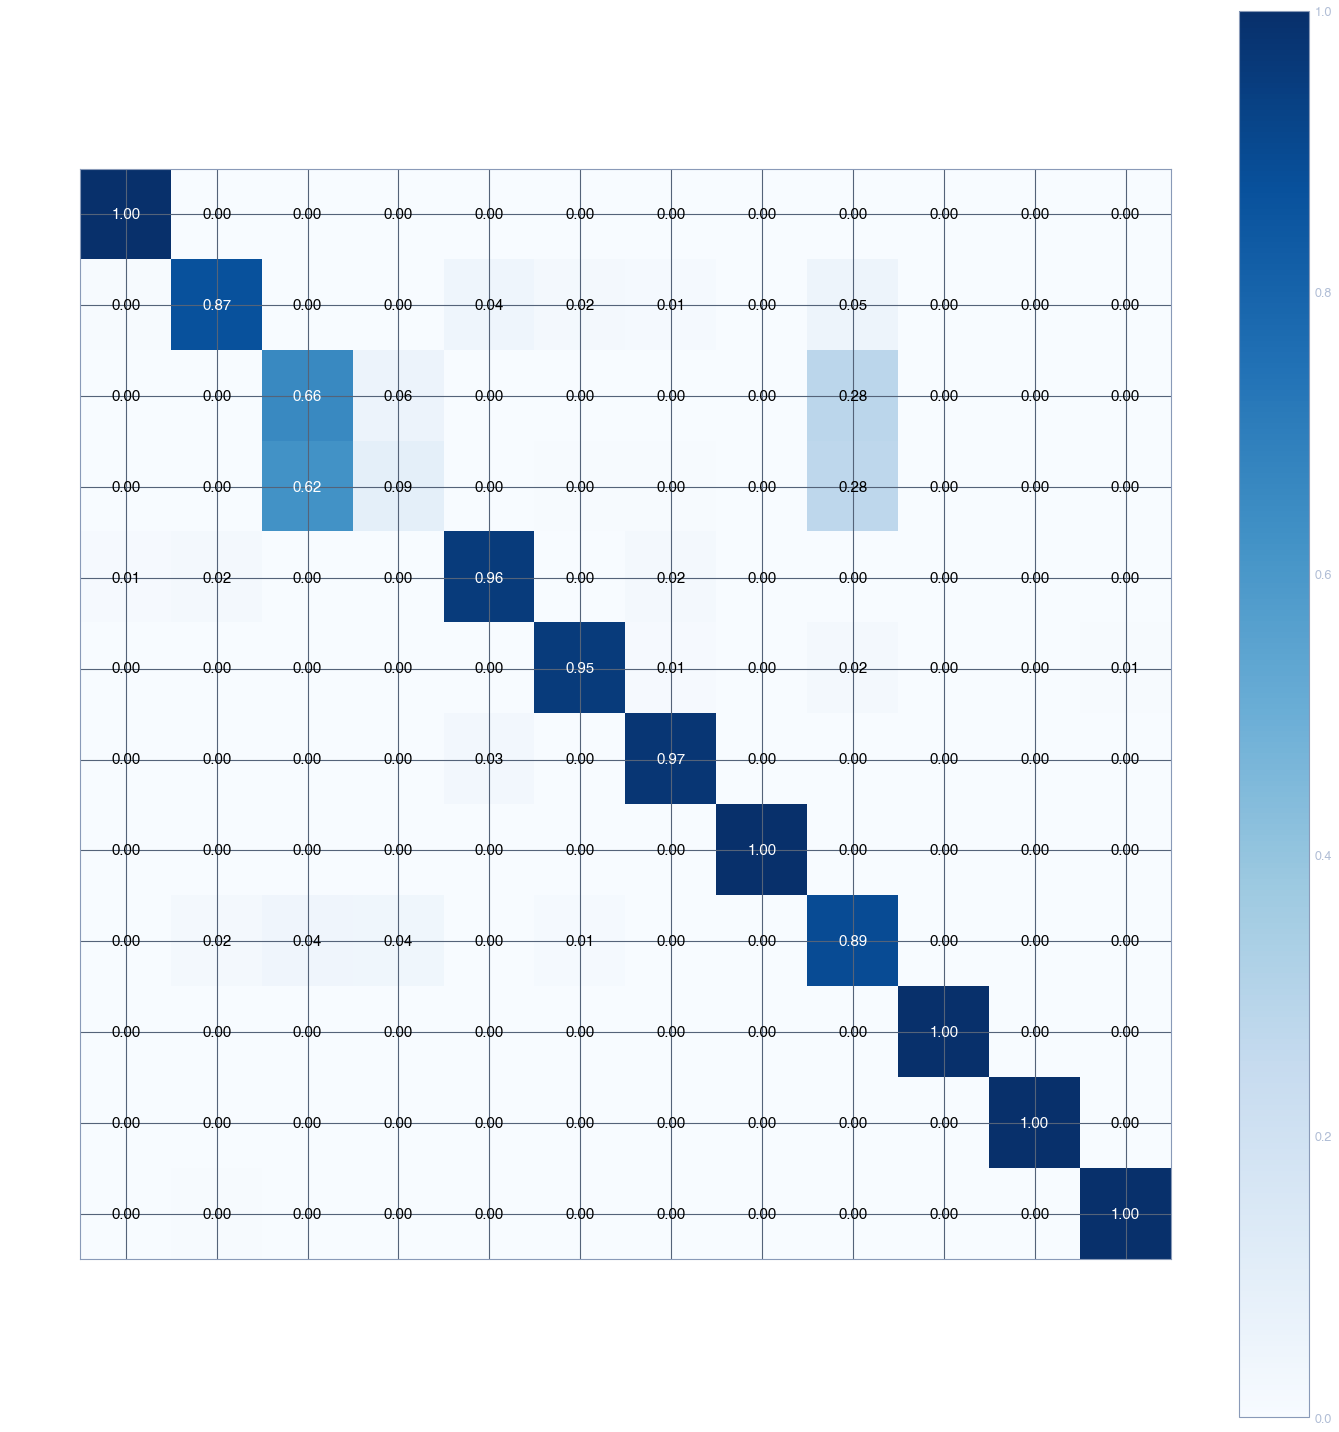

In [50]:
cm_dt_mm_scl = confusion_matrix(bal_multi_y_test, bal_multi_xgb_preds)
classes = balanced_df['Label'].unique()
plot_confusion_matrix(cm_dt_mm_scl, classes, normalize=True,
                      title='XGBoost Confusion Matrix', cmap=plt.cm.Blues)

# plt.savefig('Images/xgb_conf_matrix.png', dpi = 100)

# Anomaly Dataset

# Export Model Results

Scores

In [95]:
model_scores = pd.DataFrame({
    'Score':['Accuracy', 'F1_Score'],
    'Bal_Binary_Dummy':[bal_binary_dummy_acc, bal_binary_dummy_f1],
    'Bal_Binary_GNB':[bal_binary_gnb_acc, bal_binary_gnb_f1],
    'Bal_Binary_DT':[bal_binary_dt_acc, bal_binary_dt_f1],
    'Bal_Binary_KNN':[bal_binary_knn_acc, bal_binary_knn_f1],
    'Bal_Binary_RF':[bal_binary_rf_acc, bal_binary_rf_f1],
    'Bal_Binary_XGB':[bal_binary_xgb_acc, bal_binary_xgb_f1],
    'Bal_Multicalss_Dummy':[bal_multi_dummy_acc, bal_multi_dummy_f1],
    'Bal_Multiclass_GNB':[bal_multi_gnb_acc, bal_binary_gnb_f1],
    'Bal_Multiclass_DT':[bal_multi_dt_acc, bal_multi_dt_f1],
    'Bal_Multiclass_KNN':[bal_multi_knn_acc, bal_multi_knn_f1],
    'Bal_Multiclass_RF':[bal_multi_rf_acc, bal_multi_rf_f1],
    'Bal_Multiclass_XGB':[bal_multi_xgb_acc, bal_multi_xgb_f1]
})

model_scores

,Score,Bal_Binary_Dummy,Bal_Binary_GNB,Bal_Binary_DT,Bal_Binary_KNN,Bal_Binary_RF,Bal_Binary_XGB,Bal_Multicalss_Dummy,Bal_Multiclass_GNB,Bal_Multiclass_DT,Bal_Multiclass_KNN,Bal_Multiclass_RF,Bal_Multiclass_XGB
0,Accuracy,0.512182,0.822364,0.999091,0.997273,0.998727,1.0,0.000000,0.661636,0.924000,0.919636,0.928000,0.929455
1,F1_Score,0.512979,0.843855,0.999083,0.997254,0.998715,1.0,0.273325,0.843855,0.932673,0.926212,0.936837,0.938113


In [96]:
# model_scores.to_csv('Model_Results/Model_Scores.csv')

Feature importances

In [87]:
features = []
for i in range(1, len(bal_binary_dt_features)+1):
    features.append(f'Feature_{i}')

In [90]:
feature_importances = pd.DataFrame({
    'Feature':features,
    'Bal_Binary_DT':bal_binary_dt_features,
    'Bal_Binary_RF':bal_binary_rf_features,
    'Bal_Binary_XGB':bal_binary_xgb_features,
    'Bal_Multiclass_DT':bal_multi_dt_features,
    'Bal_Multiclass_RF':bal_multi_rf_features,
    'Bal_Multiclass_XGB':bal_multi_xgb_features
})

feature_importances.head()

,Feature,Bal_Binary_DT,Bal_Binary_RF,Bal_Binary_XGB,Bal_Multiclass_DT,Bal_Multiclass_RF,Bal_Multiclass_XGB
0,Feature_1,"(Fwd_Init_Win_Bytes, 0.6428306338135531)","(Fwd_Init_Win_Bytes, 0.13006379633919796)","(Pkt_Size_Mean, 0.36486617)","(Fwd_Init_Win_Bytes, 0.3760219415463435)","(Fwd_Init_Win_Bytes, 0.09528108518799236)","(Time_Idle_Std, 0.5322768)"
1,Feature_2,"(Pkt_Size_Mean, 0.1930210912747058)","(TCP, 0.07753190823840336)","(CWE_Flag_Count, 0.14011626)","(Pkt_Size_Mean, 0.2068695948593409)","(Pkt_Length_Min, 0.05587349828782531)","(CWE_Flag_Count, 0.09333151)"
2,Feature_3,"(ACK_Flag_Count, 0.06833403894335129)","(Pkt_Length_Min, 0.06621859113300392)","(Fwd_Init_Win_Bytes, 0.13416831)","(Pkt_Length_Max, 0.07462927073131587)","(Pkt_Size_Mean, 0.04205806720737576)","(Fwd_Pkt_Length_Std, 0.060551565)"
3,Feature_4,"(URG_Flag_Count, 0.018841893148837326)","(UDP, 0.05545832025128266)","(Fwd_Seg_Size_Min, 0.116157554)","(Fwd_Pkt_Length_Min, 0.06567930518050154)","(Fwd_Pkt_Length_Min, 0.042047606803231656)","(Fwd_Init_Win_Bytes, 0.039122608)"
4,Feature_5,"(Fwd_IAT_Std, 0.0170630742980684)","(PSH_Flag_Count, 0.04537413078590603)","(Fwd_PSH_Flags, 0.06968633)","(Fwd_IAT_Max, 0.05131909490594675)","(TCP, 0.04123283077516715)","(Pkt_Length_Min, 0.034679733)"


In [91]:
# feature_importances.to_csv('Model_Results/Feature_Importances.csv')